In [124]:
import random

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm as log_progress
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

## Some manipulations with data

In [2]:
ds = pd.read_csv('../kNN/wine.csv')
ds.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X = ds[ds.columns[1:]]
y = ds[ds.columns[:1]]
classes = y['class'].unique()
# X['Sex'] = X['Sex'].map({'M': 0, 'F': 1, 'I': 2})
X.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
def minmax(dataset):   
    result = {}
    for column in dataset.columns:
        result[column] = {'min': dataset[column].min(axis=0), 'max': dataset[column].max(axis=0)}
    return result

def normalize(dataset, minimax):
    for column in dataset.columns:
        mmc = minimax[column]
        dataset[column] = dataset[column].map(lambda val: (val - mmc['min']) / (mmc['max'] - mmc['min']))

In [5]:
normalize(X, minmax(X))
X.head()

<ipython-input-4-58934f230a95>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].map(lambda val: (val - mmc['min']) / (mmc['max'] - mmc['min']))


,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [6]:
reducer = TSNE(n_components=2)
Xr = reducer.fit_transform(X.values)

In [7]:
def draw_clusters(X, y, colors):
    plt.figure(figsize=(10,10))
    
    for i, c in enumerate(classes):
        filtered = np.array(list(map(lambda x: x[1], filter(lambda x: y[x[0]] == c, enumerate(X)))))
        x_dots, y_dots = np.transpose(filtered)
        
        plt.scatter(x_dots, y_dots, color=colors[i], label='Class no {}'.format(c))
        plt.legend()
    
    
    plt.show()

## Real classes image

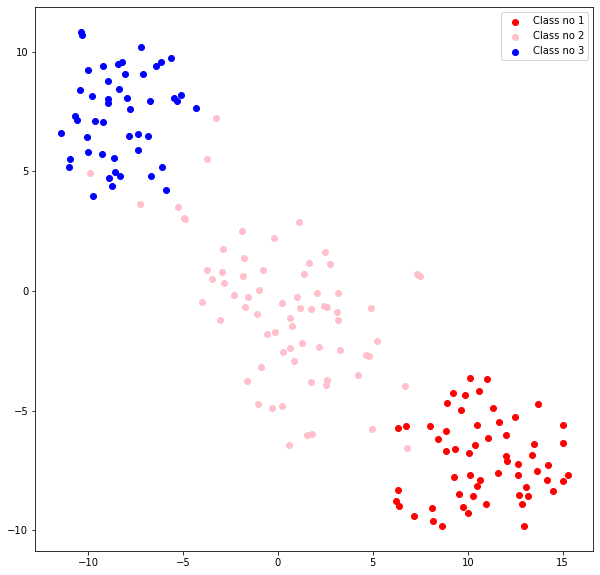

In [8]:
list(map(lambda x: x[1], filter(lambda x: y.values[x[0]] == 4, enumerate(Xr))))
draw_clusters(Xr, y.values, ['red', 'pink', 'blue'])

# KMeans algo

In [9]:
class KMeansClassifier:
    EPS = 1e-10
    
    def __init__(self, clusters, iterations=10000):
        self.clusters = clusters
        self.iterations = iterations
        
    def distance(self, centroids, X):
        distance = np.zeros((X.shape[0], self.clusters))
        for k in range(self.clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance    
        
    def update(self, X, label):
        centroids = np.zeros((self.clusters, X.shape[1]))
        for k in range(self.clusters):
            centroids[k, :] = np.mean(X[label == k, :], axis=0)
        return centroids
            
    def fit(self, X):
        self.centroids = X[np.random.permutation(X.shape[0])[:self.clusters]]
        # print(self.centroids)
        for it in range(self.iterations):
            dist = self.distance(self.centroids, X)
            closest = np.argmin(dist, axis=1)
            new_centroids = self.update(X, closest)
            
            stop = np.all(self.centroids - new_centroids < self.EPS)
            
            self.centroids = new_centroids
            if stop:
                break
                
    def predict(self, x):
        dist = self.distance(self.centroids, x)
        return np.argmin(dist, axis=1) + 1

In [168]:
clf = KMeansClassifier(clusters=3)
clf.fit(X.values)

In [169]:
predicted1 = clf.predict(X.values)

remap = {}
j = 1
for p in predicted1:
    if p not in remap:
        remap[p] = j
        j += 1

predicted = np.array(list(map(lambda x: remap[x], predicted1)))
predicted1, predicted, y.values.reshape(X.values.shape[0])

(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 2, 2, 2, 2,
        3, 2, 1, 2, 1, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 2,
        1, 2, 3, 2, 3, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2,

## Predicted image

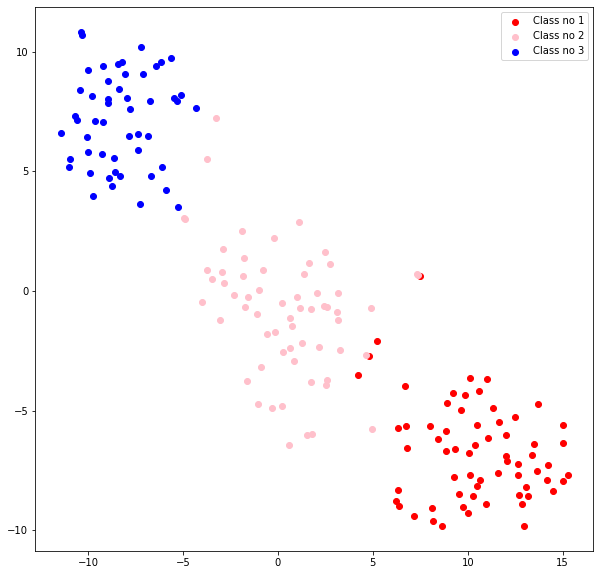

In [21]:
draw_clusters(Xr, predicted.reshape(y.values.shape), ['red', 'pink', 'blue'])

## Metrics and their drawings

In [28]:
cm = pair_confusion_matrix(y.values.T[0], predicted)

In [36]:
def AdjRand(cm):
    (TN, FP), (FN, TP) = cm
    # print(FP, FN, TP, TN, TP + FN, TP + FN + FP + TN)
    
    return 2. * (TP * TN - FN * FP) / ((TP + FN) * (FN + TN) +
                                       (TP + FP) * (FP + TN))
    # return (TP + FN) / (TP + FN + FP + TN)

In [37]:
AdjRand(cm)

0.8470966807514034

In [128]:
def inter_cluster_distances(labels, distances):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels), float('inf'))

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (distances[i, ii] < cluster_distances[labels[i], labels[ii]]):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances):
    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    for i in range(0, len(labels) - 1):
        for ii in range(i + 1, len(labels)):
            if labels[i] == labels[ii] and distances[i, ii] > diameters[
                    labels[i]]:
                diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(X, labels):
    distances = euclidean_distances(X)

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances))

    return min_distance / max_diameter

In [136]:
dunn(X.values, predicted)

0.19910378645240295

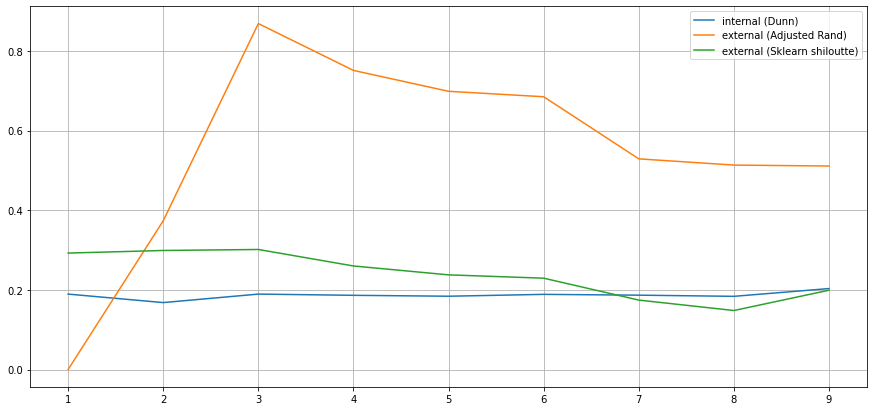

In [182]:
ks = list(range(1, 10))
res_ex = []
res_in = []
res_in_sk = []
for k in ks:
    clf = KMeansClassifier(clusters=k)
    clf.fit(X.values)
    predicted = clf.predict(X.values)
    
    remap = {}
    j = 1
    for p in predicted:
        if p not in remap:
            remap[p] = j
            j += 1
    
    predicted = np.array(list(map(lambda x: remap[x], predicted)))
    
    # print(X.values.shape)
    
    cm = pair_confusion_matrix(y.values.T[0], predicted)
    
    res_ex.append(AdjRand(cm))
    
    if k == 1:
        res_in_sk.append(silhouette_score(X.values, y.values.T[0]))
    else:
        res_in_sk.append(silhouette_score(X.values, predicted))
    
    if k == 1:
        res_in.append(dunn(X.values, y.values.T[0]))
    else:
        res_in.append(dunn(X.values, predicted))

    
plt.figure(figsize=(15, 7))
plt.grid('-')
plt.plot(ks, res_in, label='internal (Dunn)')
plt.plot(ks, res_ex, label='external (Adjusted Rand)')
plt.plot(ks, res_in_sk, label='external (Sklearn shiloutte)')
plt.legend()